# 次元削除

## PCA
`PCA`(主成分分析)は群を抜いてよく使われる次元削除アルゴリズムである。

In [15]:
import numpy as np
import matplotlib.pyplot as plt

## 主成分
PCAは訓練セットの分散を最大限に維持する軸を見つける。訓練セットから主成分を見つけるにはどうすればいいのか。
訓練セット行列$X$を$U \cdot \sum \cdot V^t$の３行列のドット積に分解出来る`特異値分解`という行列分解テクニックがある

$
\mathbf{V} =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

In [16]:
# 三次元のデータを作成する
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [17]:
X[0]

array([-1.01570027, -0.55091331, -0.26132626])

In [18]:
X_cesntered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_cesntered)

c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

### 低次のd次元への射影
全ての主成分が見つかったら、最初のd次元の成分が定義する平面に射影すれば、データセットをd次元に削減できる。  
訓練セットを平面に射影するには、訓練セット行列$X$と最初のd個の主成分によって定義される行列$W_d$のドット積を計算すれば良い。

In [19]:
w2 = Vt.T[:, :2]
X2D = X_cesntered.dot(w2)

In [20]:
X2D[:3]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729]])

### scikit-learnの使い方
scikit-learnを使用して次元を削減する

In [21]:
from sklearn.decomposition import PCA

In [22]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [23]:
X2D[:3]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729]])

### 因子寄与率
`explained_varianced_variance_rate_`変数から得られる個々の主成分の因子寄与率も重要な情報である。

In [24]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

この値はデータセットの84.2%が第1軸に沿ったものであり、14.6%が第2軸にそったものだと表している。

### 適切な次数の選択
次数をいくつまで削減するかは、無作為に選ぶのではなく、各次元に沿った因子寄与率の合計が十分な割合になるような形を選ぶようにする。

In [25]:
from sklearn.datasets import fetch_mldata

In [26]:
mnist = fetch_mldata('MNIST original')

In [27]:
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [28]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [30]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [44]:
for i, c in enumerate(cumsum):
    if c > 0.95:
        print(i)
        break

153


95%の因子寄与率ならば153次元まで削減すれば良い

Text(0, 0.5, 'explained_variance_ratio_')

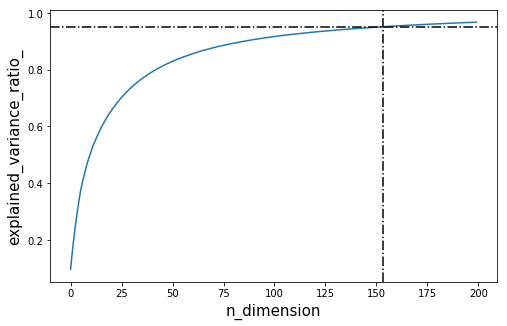

In [54]:
plt.figure(figsize=(8, 5))
plt.plot(cumsum[:200])
plt.axhline(0.95, ls='-.', color='black')  
plt.axvline(153, ls='-.', color='black')

plt.xlabel('n_dimension', size=15)
plt.ylabel('explained_variance_ratio_', size=15)

### 圧縮のためのPCA
上のグラフから分散が95%維持されるようにPCAに適用するとオリジナルの784から150くらいに減ることがわかる。  
分散の大半を維持しつつも、サイズは元のサイズの20%ほどに圧縮されている。

PCAの射影を逆変換すれば次元を削除したデータセットを元の784次元に戻すことができる。

In [55]:
pca = PCA(n_components=153)
X_reduced = pca.fit_transform(X_train)
y_recovered = pca.inverse_transform(X_reduced)

In [57]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")